## **Problem Statement**

**You are hired by one of the leading news channels CNBE who wants to analyze recent elections. This survey was conducted on 1525 voters with 9 variables. You have to build a model, to predict which party a voter will vote for on the basis of the given information, to create an exit poll that will help in predicting overall win and seats covered by a particular party.**

In [ ]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk # this is the Natural Language Tool Kit which contains a lot of functionalities for text analytics
import random
import string # this is used for string manipulations
from gensim.models import Word2Vec

In [ ]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('movie_reviews')
nltk.download('inaugural')
from nltk.corpus import inaugural
inaugural.fileids()
inaugural.raw('1941-Roosevelt.txt')
inaugural.raw('1961-Kennedy.txt')
inaugural.raw('1973-Nixon.txt')

[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


'Mr. Vice President, Mr. Speaker, Mr. Chief Justice, Senator Cook, Mrs. Eisenhower, and my fellow citizens of this great and good country we share together:\n\nWhen we met here four years ago, America was bleak in spirit, depressed by the prospect of seemingly endless war abroad and of destructive conflict at home.\n\nAs we meet here today, we stand on the threshold of a new era of peace in the world.\n\nThe central question before us is: How shall we use that peace? Let us resolve that this era we are about to enter will not be what other postwar periods have so often been: a time of retreat and isolation that leads to stagnation at home and invites new danger abroad.\n\nLet us resolve that this will be what it can become: a time of great responsibilities greatly borne, in which we renew the spirit and the promise of America as we enter our third century as a nation.\n\nThis past year saw far-reaching results from our new policies for peace. By continuing to revitalize our traditional

**1.1 Read the dataset. Do the descriptive statistics and do the null value condition check.**

In [ ]:
df= pd.read_excel("Election_Data.xlsx")

In [ ]:
df.shape

(1525, 10)

In [ ]:
df.head()

,Unnamed: 0,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,1,Labour,43,3,3,4,1,2,2,female
1,2,Labour,36,4,4,4,4,5,2,male
2,3,Labour,35,4,4,5,2,3,2,male
3,4,Labour,24,4,2,2,1,4,0,female
4,5,Labour,41,2,2,1,1,6,2,male


In [ ]:
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political.knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 107.4+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1525.0,54.182295,15.711209,24.0,41.0,53.0,67.0,93.0
economic.cond.national,1525.0,3.245902,0.880969,1.0,3.0,3.0,4.0,5.0
economic.cond.household,1525.0,3.140328,0.929951,1.0,3.0,3.0,4.0,5.0
Blair,1525.0,3.334426,1.174824,1.0,2.0,4.0,4.0,5.0
Hague,1525.0,2.746885,1.230703,1.0,2.0,2.0,4.0,5.0
Europe,1525.0,6.728525,3.297538,1.0,4.0,6.0,10.0,11.0
political.knowledge,1525.0,1.542295,1.083315,0.0,0.0,2.0,2.0,3.0


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
vote,1525,2,Labour,1063
gender,1525,2,female,812


In [ ]:
df.duplicated().sum()

8

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(1517, 9)

In [ ]:
round(df.skew(),3)

age                        0.140
economic.cond.national    -0.238
economic.cond.household   -0.144
Blair                     -0.540
Hague                      0.146
Europe                    -0.142
political.knowledge       -0.423
dtype: float64

**1.2 Perform Univariate and Bivariate Analysis. Do exploratory data analysis. Check for Outliers.**

In [ ]:
pre_check_eda = pd.DataFrame()
pre_check_eda['Null values']=df.isnull().sum()
pre_check_eda['Data types']=df.dtypes
pre_check_eda

,Null values,Data types
vote,0,object
age,0,int64
economic.cond.national,0,int64
economic.cond.household,0,int64
Blair,0,int64
Hague,0,int64
Europe,0,int64
political.knowledge,0,int64
gender,0,object


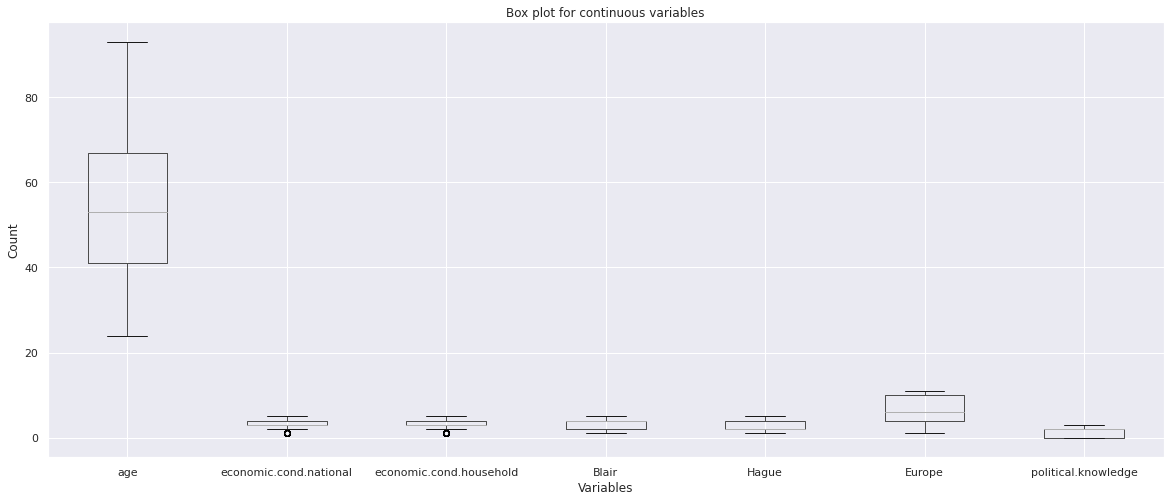

In [ ]:
plt.figure(figsize=(20,8))
df[['age', 'economic.cond.national', 'economic.cond.household', 'Blair', 'Hague', 'Europe', 'political.knowledge']].boxplot(vert=1)
plt.title('Box plot for continuous variables')
plt.ylabel('Count')
plt.xlabel('Variables')
plt.show()

In [ ]:
for column in df[[ 'vote', 'gender']]:
    print(column.upper(),': ',df[column].nunique())
    print(df[column].value_counts().sort_values())
    print('\n')

VOTE :  2
Conservative     460
Labour          1057
Name: vote, dtype: int64


GENDER :  2
male      709
female    808
Name: gender, dtype: int64




**Checking for Possible columns which are categorical but are not having data type "object"**

In [ ]:
for column in df[[ 'economic.cond.national', 'economic.cond.household', 'Blair', 'Hague', 'Europe', 'political.knowledge']]:
    print(column.upper(),': ',df[column].nunique())
    print(df[column].value_counts().sort_values())
    print('\n')

ECONOMIC.COND.NATIONAL :  5
1     37
5     82
2    256
4    538
3    604
Name: economic.cond.national, dtype: int64


ECONOMIC.COND.HOUSEHOLD :  5
1     65
5     92
2    280
4    435
3    645
Name: economic.cond.household, dtype: int64


BLAIR :  5
3      1
1     97
5    152
2    434
4    833
Name: Blair, dtype: int64


HAGUE :  5
3     37
5     73
1    233
4    557
2    617
Name: Hague, dtype: int64


EUROPE :  11
2      77
7      86
10    101
1     109
9     111
8     111
5     123
4     126
3     128
6     207
11    338
Name: Europe, dtype: int64


POLITICAL.KNOWLEDGE :  4
1     38
3    249
0    454
2    776
Name: political.knowledge, dtype: int64




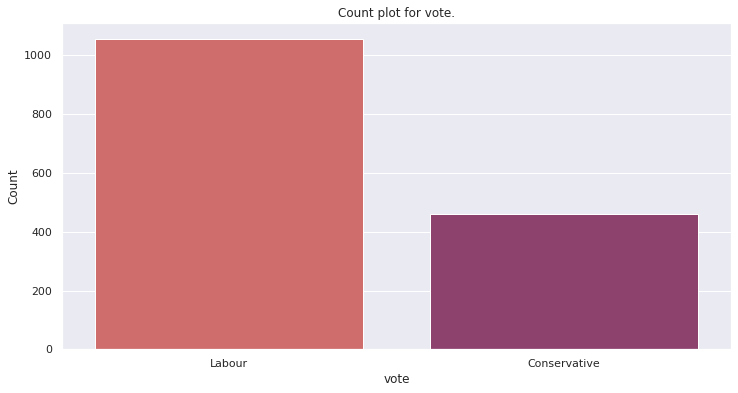

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(df['vote'], palette='flare')
plt.title('Count plot for vote.')
plt.xlabel('vote')
plt.ylabel('Count')
plt.show()

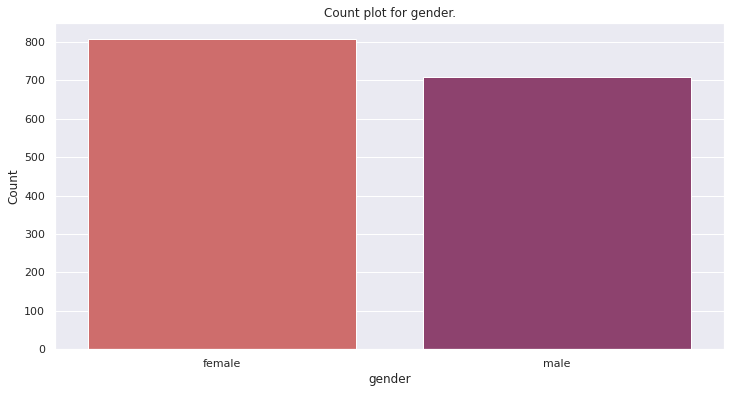

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(df['gender'], palette='flare')
plt.title('Count plot for gender.')
plt.xlabel('gender')
plt.ylabel('Count')
plt.show()

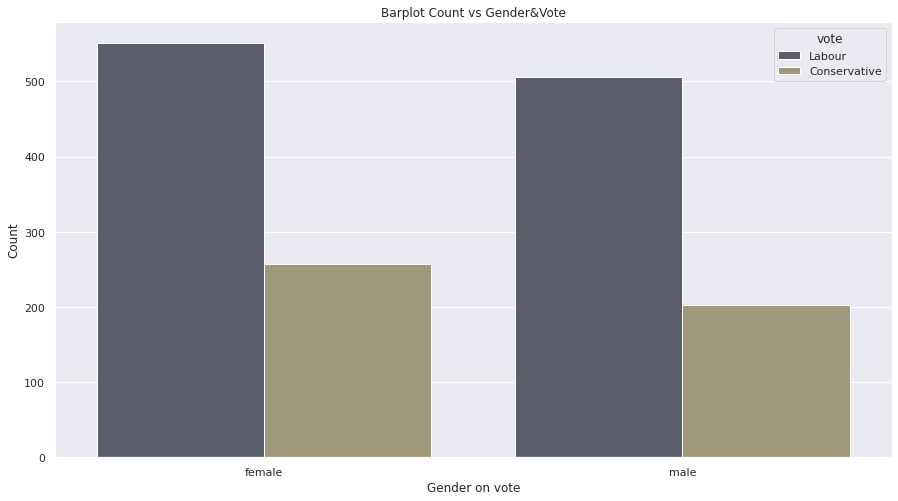

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(df['gender'], hue=df['vote'], palette='cividis')
plt.title('Barplot Count vs Gender&Vote')
plt.xlabel('Gender on vote')
plt.ylabel('Count')
plt.show()

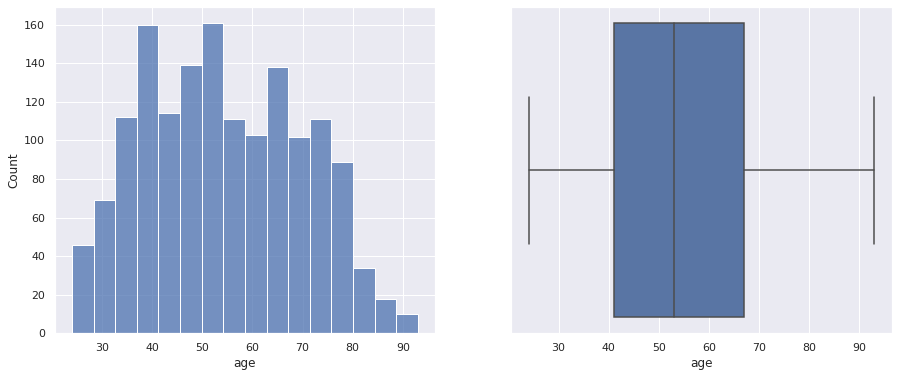

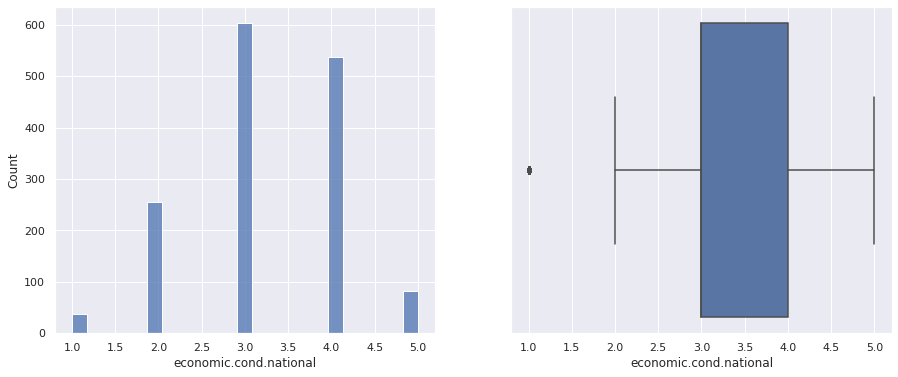

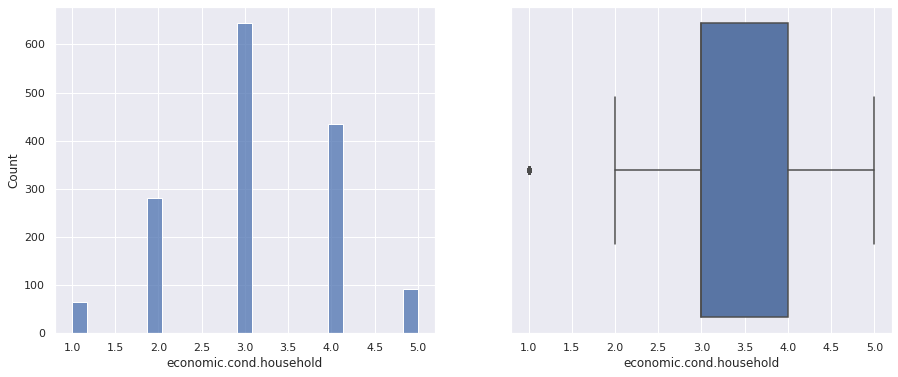

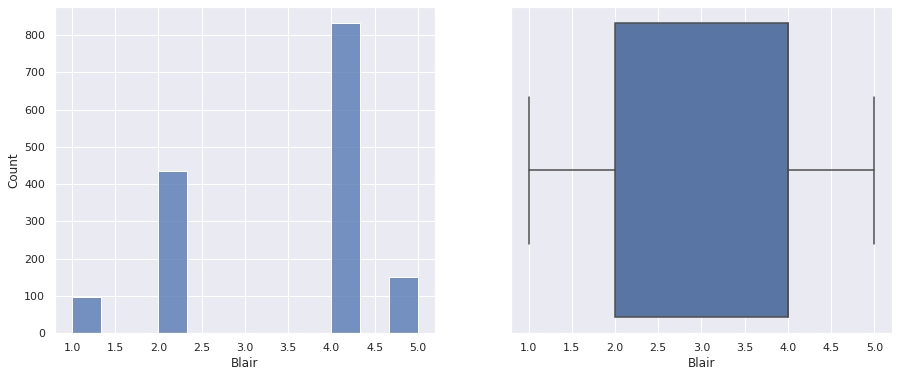

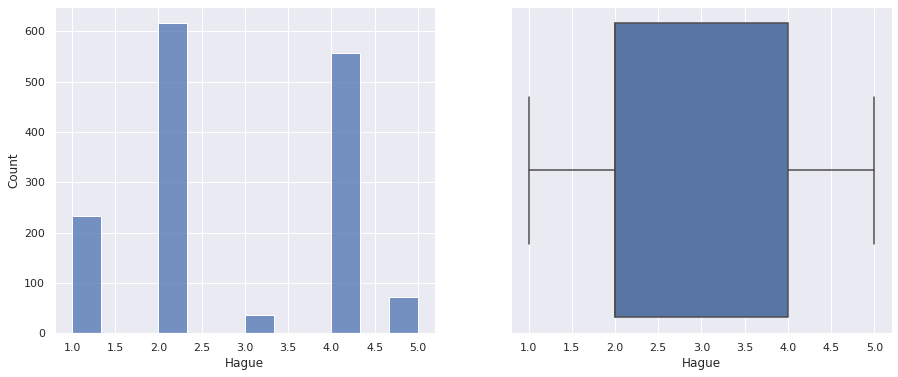

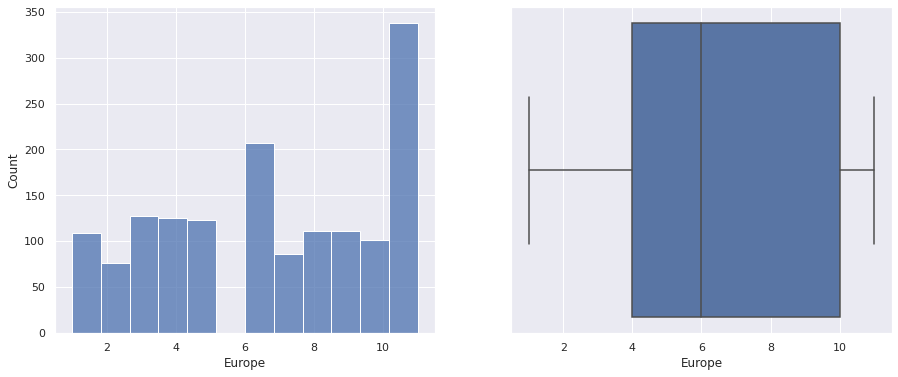

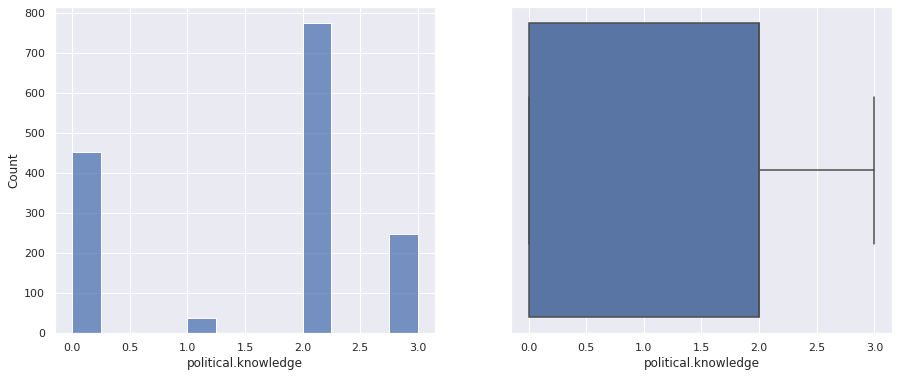

In [ ]:
numerical = df.select_dtypes('number').columns
feature_list = df.columns
for i in numerical:
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    sns.histplot(data=df, x=i, ax=ax[0])
    sns.boxplot(x=i, data=df, width=0.9, ax=ax[1])

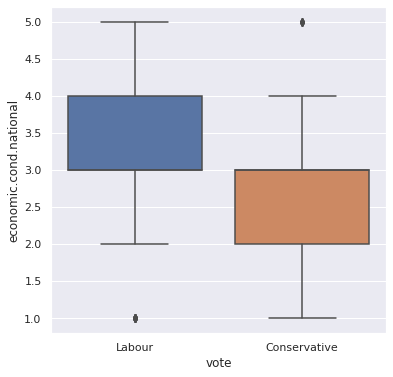

In [ ]:
plt.figure(figsize=(6,6))
sns.boxplot(df["vote"], df['economic.cond.national']) 
plt.show()

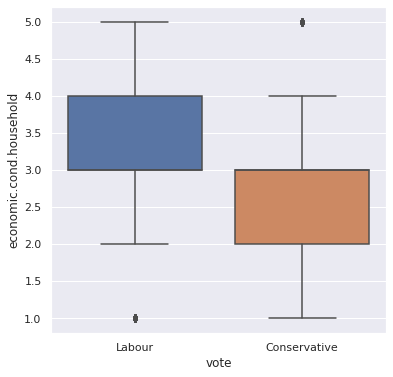

In [ ]:
plt.figure(figsize=(6,6))
sns.boxplot(x=df["vote"], y=df['economic.cond.household']) 
plt.show()

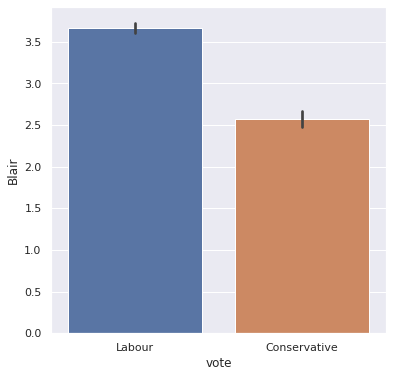

In [ ]:
plt.figure(figsize=(6,6))
sns.barplot(df["vote"], df['Blair']) 
plt.show()

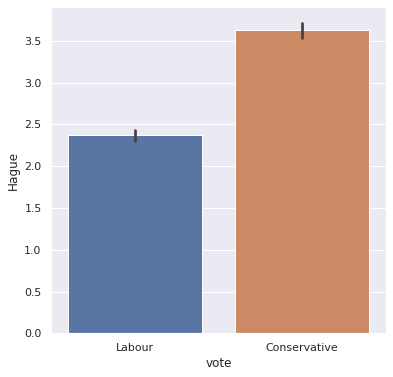

In [ ]:
plt.figure(figsize=(6,6))
sns.barplot(df["vote"], df['Hague']) 
plt.show()

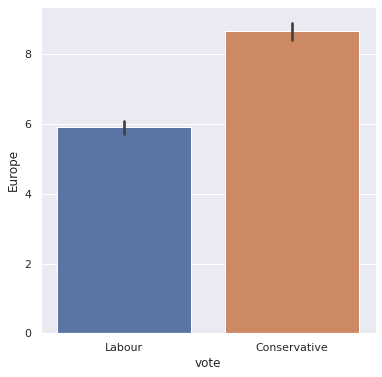

In [ ]:
plt.figure(figsize=(6,6))
sns.barplot(df["vote"], df['Europe']) 
plt.show()

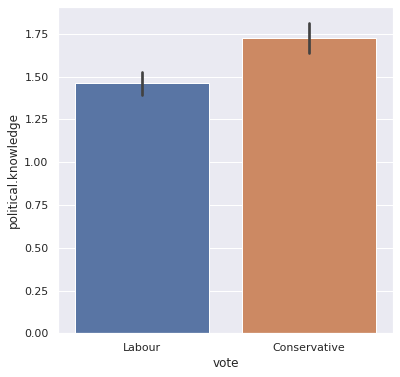

In [ ]:
plt.figure(figsize=(6,6))
sns.barplot(df["vote"], df['political.knowledge']) 
plt.show()

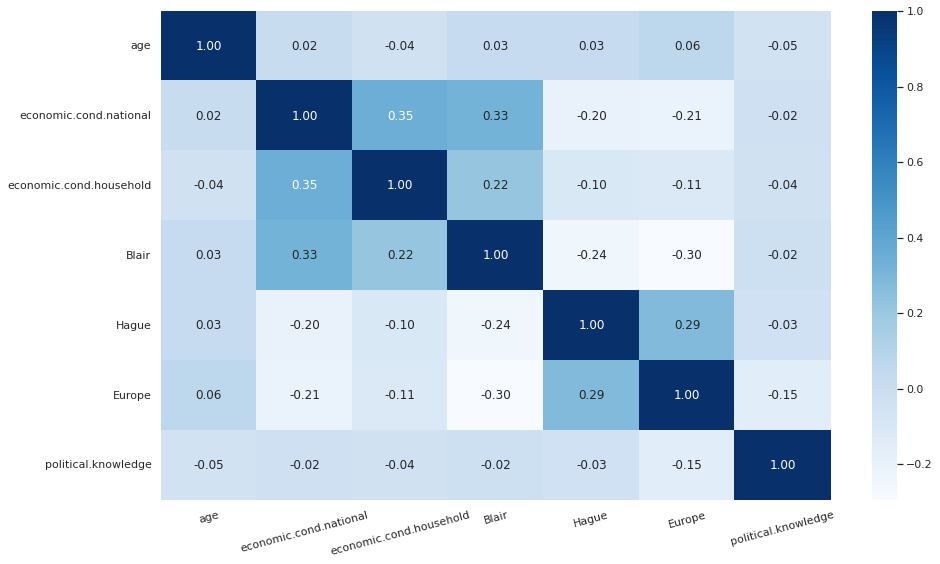

In [ ]:
plt.figure(figsize = (15,9))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.xticks(rotation=15)
plt.show()

<Figure size 432x144 with 0 Axes>

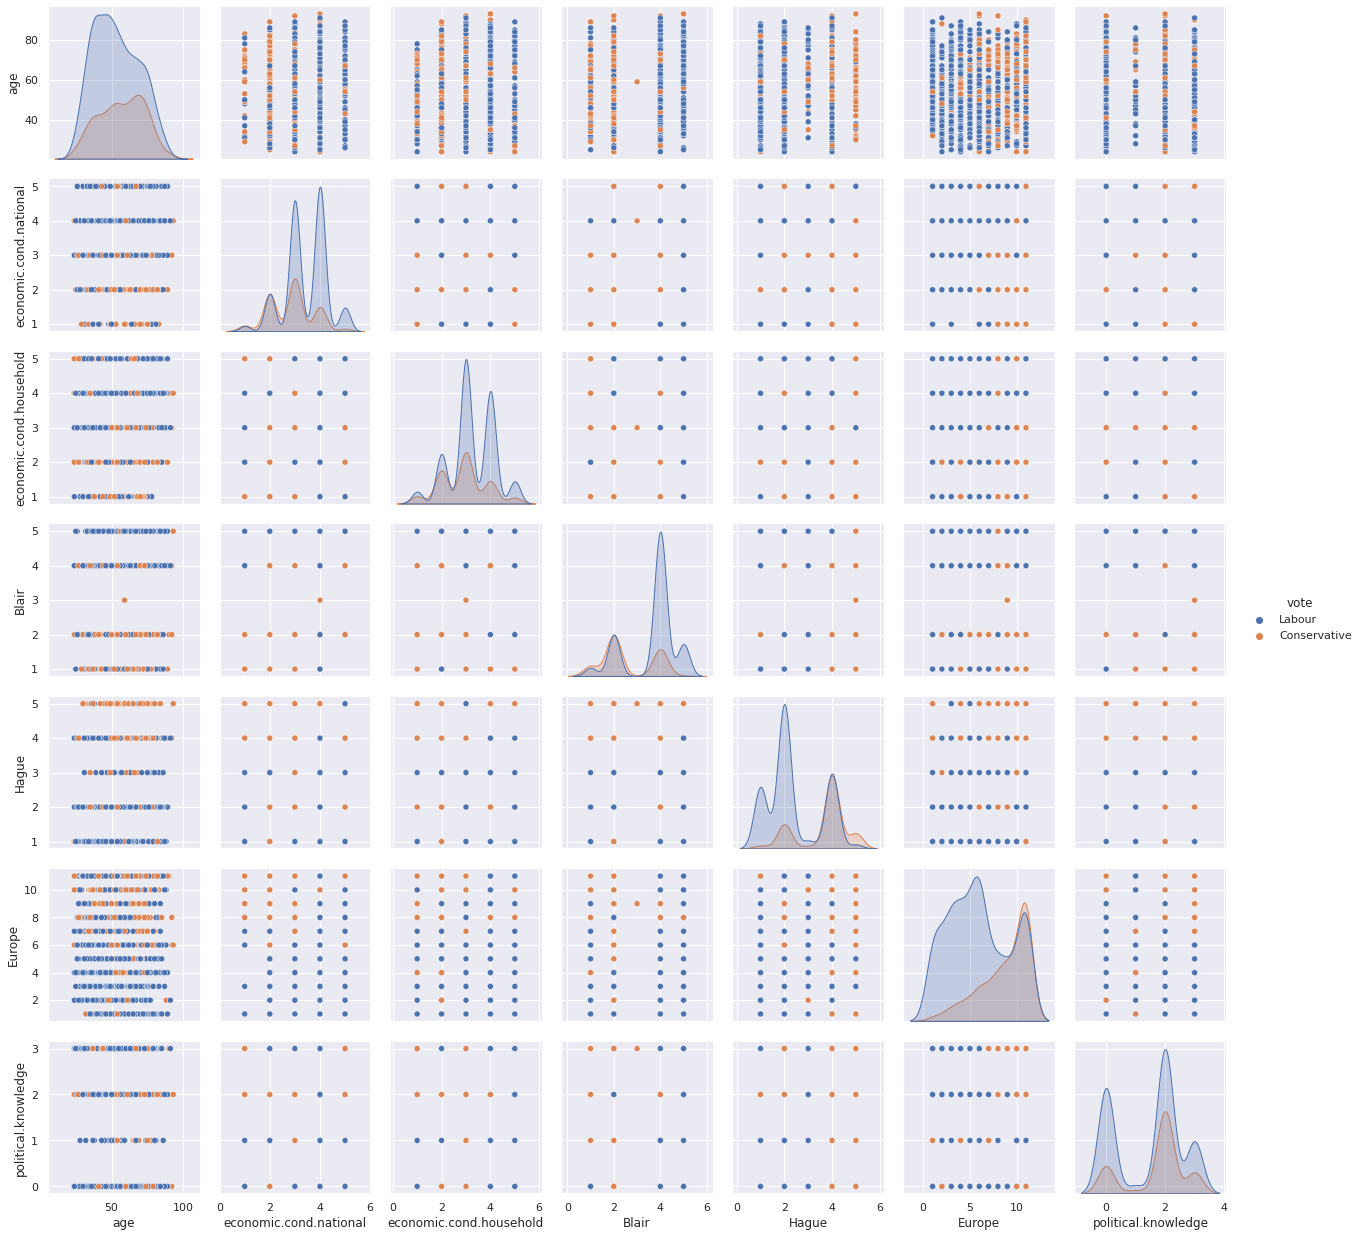

In [ ]:
plt.figure(figsize = (6,2))
sns.pairplot(df,hue='vote')

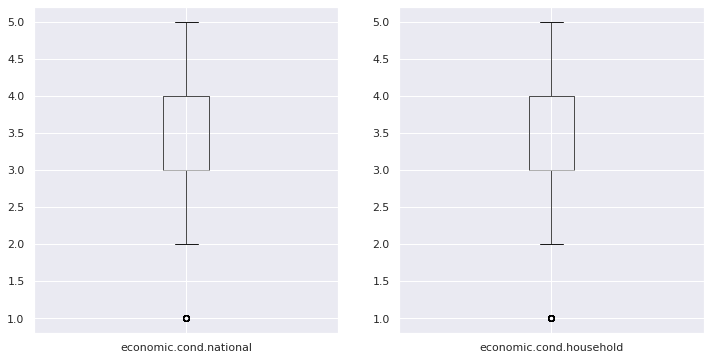

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
df.boxplot(column=['economic.cond.national'],  ax=ax[0])
df.boxplot(column=['economic.cond.household'],  ax=ax[1])

**1.3 Encode the data (having string values) for Modelling. Is Scaling necessary here or not? Data Split: Split the data into train and test(70:30)**

In [ ]:
cat = [ 'vote', 'gender']

In [ ]:
df = pd.get_dummies(df, columns=cat, drop_first=True)

In [ ]:
df.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,vote_Labour,gender_male
0,43,3,3,4,1,2,2,1,0
1,36,4,4,4,4,5,2,1,1
2,35,4,4,5,2,3,2,1,1
3,24,4,2,2,1,4,0,1,0
4,41,2,2,1,1,6,2,1,1


In [ ]:
df.rename(columns={"vote_Labour":"Labour=1_Conservative=0", "gender_male":"Male=1_Female=0"}, inplace=True)
df.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,Labour=1_Conservative=0,Male=1_Female=0
0,43,3,3,4,1,2,2,1,0
1,36,4,4,4,4,5,2,1,1
2,35,4,4,5,2,3,2,1,1
3,24,4,2,2,1,4,0,1,0
4,41,2,2,1,1,6,2,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      1517 non-null   int64
 1   economic.cond.national   1517 non-null   int64
 2   economic.cond.household  1517 non-null   int64
 3   Blair                    1517 non-null   int64
 4   Hague                    1517 non-null   int64
 5   Europe                   1517 non-null   int64
 6   political.knowledge      1517 non-null   int64
 7   Labour=1_Conservative=0  1517 non-null   uint8
 8   Male=1_Female=0          1517 non-null   uint8
dtypes: int64(7), uint8(2)
memory usage: 130.1 KB


In [ ]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
age,1517.0,54.24,15.70,24.0,41.0,53.0,67.0,93.0
economic.cond.national,1517.0,3.25,0.88,1.0,3.0,3.0,4.0,5.0
economic.cond.household,1517.0,3.14,0.93,1.0,3.0,3.0,4.0,5.0
Blair,1517.0,3.34,1.17,1.0,2.0,4.0,4.0,5.0
Hague,1517.0,2.75,1.23,1.0,2.0,2.0,4.0,5.0
Europe,1517.0,6.74,3.30,1.0,4.0,6.0,10.0,11.0
political.knowledge,1517.0,1.54,1.08,0.0,0.0,2.0,2.0,3.0
Labour=1_Conservative=0,1517.0,0.70,0.46,0.0,0.0,1.0,1.0,1.0
Male=1_Female=0,1517.0,0.47,0.50,0.0,0.0,0.0,1.0,1.0


In [ ]:
round(np.var(df),2) #variance  

age                        246.38
economic.cond.national       0.78
economic.cond.household      0.87
Blair                        1.38
Hague                        1.52
Europe                      10.88
political.knowledge          1.18
Labour=1_Conservative=0      0.21
Male=1_Female=0              0.25
dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler #Scaling
minmax = MinMaxScaler()
df_scaled = minmax.fit_transform(df)
df_scaled = pd.DataFrame(data=df_scaled, columns=df.columns)
df_scaled.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,Labour=1_Conservative=0,Male=1_Female=0
0,0.275362,0.50,0.50,0.75,0.00,0.1,0.666667,1.0,0.0
1,0.173913,0.75,0.75,0.75,0.75,0.4,0.666667,1.0,1.0
2,0.159420,0.75,0.75,1.00,0.25,0.2,0.666667,1.0,1.0
3,0.000000,0.75,0.25,0.25,0.00,0.3,0.000000,1.0,0.0
4,0.246377,0.25,0.25,0.00,0.00,0.5,0.666667,1.0,1.0


In [ ]:
round(np.var(df_scaled),2) #variance  

age                        0.05
economic.cond.national     0.05
economic.cond.household    0.05
Blair                      0.09
Hague                      0.09
Europe                     0.11
political.knowledge        0.13
Labour=1_Conservative=0    0.21
Male=1_Female=0            0.25
dtype: float64

In [ ]:
round(df_scaled.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
age,1517.0,0.44,0.23,0.0,0.25,0.42,0.62,1.0
economic.cond.national,1517.0,0.56,0.22,0.0,0.50,0.50,0.75,1.0
economic.cond.household,1517.0,0.53,0.23,0.0,0.50,0.50,0.75,1.0
Blair,1517.0,0.58,0.29,0.0,0.25,0.75,0.75,1.0
Hague,1517.0,0.44,0.31,0.0,0.25,0.25,0.75,1.0
Europe,1517.0,0.57,0.33,0.0,0.30,0.50,0.90,1.0
political.knowledge,1517.0,0.51,0.36,0.0,0.00,0.67,0.67,1.0
Labour=1_Conservative=0,1517.0,0.70,0.46,0.0,0.00,1.00,1.00,1.0
Male=1_Female=0,1517.0,0.47,0.50,0.0,0.00,0.00,1.00,1.0


In [ ]:
round(df_scaled['Labour=1_Conservative=0'].value_counts(normalize=True)*100, 2)

1.0    69.68
0.0    30.32
Name: Labour=1_Conservative=0, dtype: float64

In [ ]:
df = df_scaled
df.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,Labour=1_Conservative=0,Male=1_Female=0
0,0.275362,0.50,0.50,0.75,0.00,0.1,0.666667,1.0,0.0
1,0.173913,0.75,0.75,0.75,0.75,0.4,0.666667,1.0,1.0
2,0.159420,0.75,0.75,1.00,0.25,0.2,0.666667,1.0,1.0
3,0.000000,0.75,0.25,0.25,0.00,0.3,0.000000,1.0,0.0
4,0.246377,0.25,0.25,0.00,0.00,0.5,0.666667,1.0,1.0


In [ ]:
X = df.drop("Labour=1_Conservative=0", axis=1)
y = df.pop("Labour=1_Conservative=0")
X.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,Male=1_Female=0
0,0.275362,0.50,0.50,0.75,0.00,0.1,0.666667,0.0
1,0.173913,0.75,0.75,0.75,0.75,0.4,0.666667,1.0
2,0.159420,0.75,0.75,1.00,0.25,0.2,0.666667,1.0
3,0.000000,0.75,0.25,0.25,0.00,0.3,0.000000,0.0
4,0.246377,0.25,0.25,0.00,0.00,0.5,0.666667,1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=123)

In [ ]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

X_train (1061, 8)
X_test (456, 8)
train_labels (1061,)
test_labels (456,)


In [ ]:
train_labels.value_counts(normalize=True)

1.0    0.69934
0.0    0.30066
Name: Labour=1_Conservative=0, dtype: float64

In [ ]:
test_labels.value_counts(normalize=True)

1.0    0.690789
0.0    0.309211
Name: Labour=1_Conservative=0, dtype: float64

**1.4 Apply Logistic Regression and LDA (linear discriminant analysis).**

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,train_labels)

LogisticRegression()

In [ ]:
print('model.score_train', model.score(X_train, train_labels))
print('model.score_test', model.score(X_test, test_labels))

model.score_train 0.8416588124410933
model.score_test 0.8179824561403509


In [ ]:
ytest_predict =  model.predict(X_test)
ytrain_predict = model.predict(X_train)

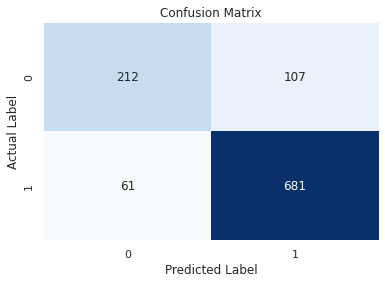

In [ ]:
confusion_matrix(train_labels, ytrain_predict)
sns.heatmap(confusion_matrix(train_labels, ytrain_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.66      0.72       319
         1.0       0.86      0.92      0.89       742

    accuracy                           0.84      1061
   macro avg       0.82      0.79      0.80      1061
weighted avg       0.84      0.84      0.84      1061



AUC: 0.892


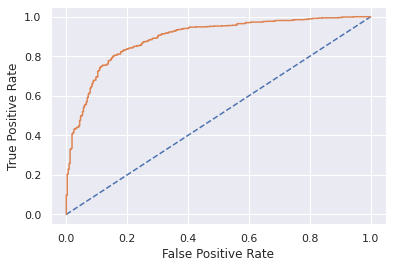

In [ ]:
probs = model.predict_proba(X_train)
probs = probs[:, 1]
ct_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % ct_train_auc)
ct_train_fpr, ct_train_tpr, ct_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_train_fpr, ct_train_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

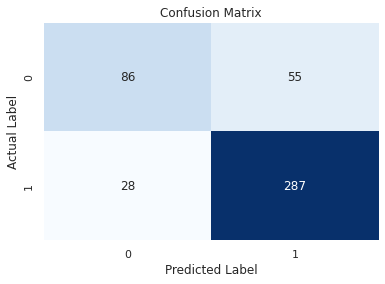

In [ ]:
confusion_matrix(test_labels, ytest_predict)
sns.heatmap(confusion_matrix(test_labels, ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

         0.0       0.75      0.61      0.67       141
         1.0       0.84      0.91      0.87       315

    accuracy                           0.82       456
   macro avg       0.80      0.76      0.77       456
weighted avg       0.81      0.82      0.81       456



AUC: 0.883


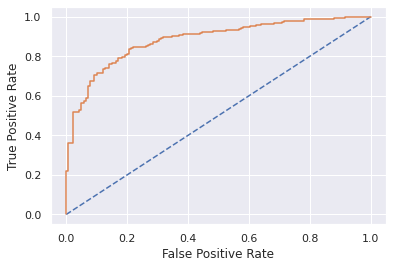

In [ ]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]
ct_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % ct_test_auc)
ct_test_fpr, ct_test_tpr, ct_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_test_fpr, ct_test_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**LDA Model**

In [ ]:
clf = LinearDiscriminantAnalysis()
model=clf.fit(X_train,train_labels)

In [ ]:
print('model.score_train', model.score(X_train, train_labels))
print('model.score_test', model.score(X_test, test_labels))

model.score_train 0.8388312912346843
model.score_test 0.8245614035087719


In [ ]:
ytest_predict =  model.predict(X_test)
ytrain_predict = model.predict(X_train)

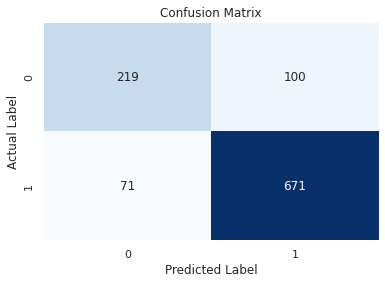

In [ ]:
confusion_matrix(train_labels, ytrain_predict)
sns.heatmap(confusion_matrix(train_labels, ytrain_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72       319
         1.0       0.87      0.90      0.89       742

    accuracy                           0.84      1061
   macro avg       0.81      0.80      0.80      1061
weighted avg       0.84      0.84      0.84      1061



AUC: 0.892


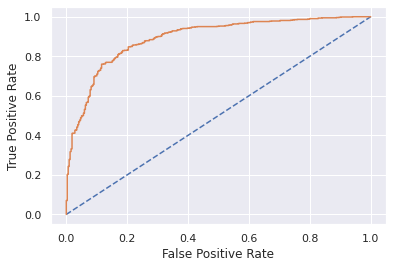

In [ ]:
probs = model.predict_proba(X_train)
probs = probs[:, 1]
ct_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % ct_train_auc)
ct_train_fpr, ct_train_tpr, ct_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_train_fpr, ct_train_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

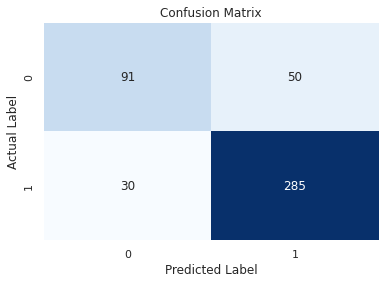

In [ ]:
confusion_matrix(test_labels, ytest_predict)
sns.heatmap(confusion_matrix(test_labels, ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

         0.0       0.75      0.65      0.69       141
         1.0       0.85      0.90      0.88       315

    accuracy                           0.82       456
   macro avg       0.80      0.78      0.79       456
weighted avg       0.82      0.82      0.82       456



AUC: 0.882


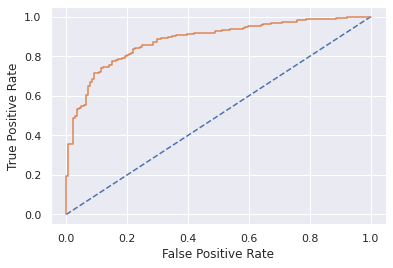

In [ ]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]
ct_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % ct_test_auc)
ct_test_fpr, ct_test_tpr, ct_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_test_fpr, ct_test_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**1.5 Apply KNN Model and Naïve Bayes Model. Interpret the results.**

In [ ]:
#KNN Model
from sklearn.neighbors import KNeighborsClassifier

KNN_model=KNeighborsClassifier()
KNN_model.fit(X_train,train_labels)

KNeighborsClassifier()

In [ ]:
print(KNN_model.score(X_train, train_labels))
print(KNN_model.score(X_test, test_labels))

0.8680490103675778
0.7982456140350878


In [ ]:
ytest_predict =  KNN_model.predict(X_test)
ytrain_predict = KNN_model.predict(X_train)

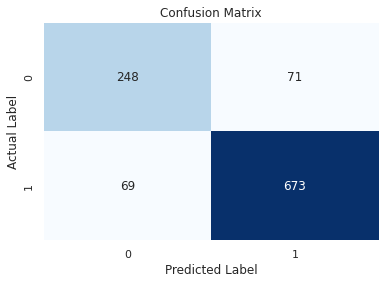

In [ ]:
confusion_matrix(train_labels, ytrain_predict)
sns.heatmap(confusion_matrix(train_labels, ytrain_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       319
         1.0       0.90      0.91      0.91       742

    accuracy                           0.87      1061
   macro avg       0.84      0.84      0.84      1061
weighted avg       0.87      0.87      0.87      1061



AUC: 0.935


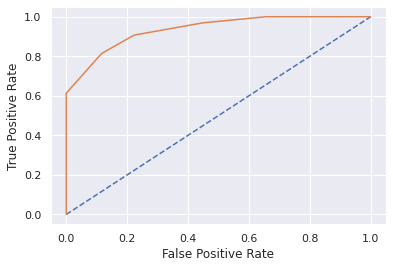

In [ ]:
probs = KNN_model.predict_proba(X_train)
probs = probs[:, 1]
ct_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % ct_train_auc)
ct_train_fpr, ct_train_tpr, ct_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_train_fpr, ct_train_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

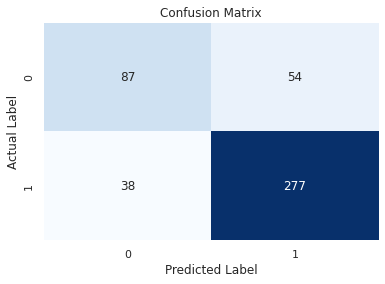

In [ ]:
confusion_matrix(test_labels, ytest_predict)
sns.heatmap(confusion_matrix(test_labels, ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

         0.0       0.70      0.62      0.65       141
         1.0       0.84      0.88      0.86       315

    accuracy                           0.80       456
   macro avg       0.77      0.75      0.76       456
weighted avg       0.79      0.80      0.79       456



AUC: 0.826


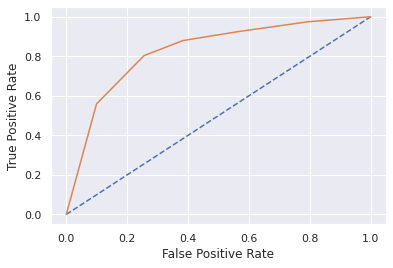

In [ ]:
probs = KNN_model.predict_proba(X_test)
probs = probs[:, 1]
ct_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % ct_test_auc)
ct_test_fpr, ct_test_tpr, ct_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_test_fpr, ct_test_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Tunning**

In [ ]:
KNN_model=KNeighborsClassifier(n_neighbors=7)
KNN_model.fit(X_train,train_labels)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
from sklearn import metrics
y_train_predict=KNN_model.predict(X_train)
KNN_model_score=KNN_model.score(X_train,train_labels)
print(KNN_model_score)
print(metrics.confusion_matrix(train_labels,y_train_predict))
print(metrics.classification_report(train_labels,y_train_predict))

0.8586239396795476
[[236  83]
 [ 67 675]]
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76       319
         1.0       0.89      0.91      0.90       742

    accuracy                           0.86      1061
   macro avg       0.83      0.82      0.83      1061
weighted avg       0.86      0.86      0.86      1061



In [ ]:
y_test_predict=KNN_model.predict(X_test)
KNN_model_score=KNN_model.score(X_test,test_labels)
print(KNN_model_score)
print(metrics.confusion_matrix(test_labels,y_test_predict))
print(metrics.classification_report(test_labels,y_test_predict))


0.7982456140350878
[[ 87  54]
 [ 38 277]]
              precision    recall  f1-score   support

         0.0       0.70      0.62      0.65       141
         1.0       0.84      0.88      0.86       315

    accuracy                           0.80       456
   macro avg       0.77      0.75      0.76       456
weighted avg       0.79      0.80      0.79       456



In [ ]:
# empty list that will hold accuracy scores
ac_scores = []

# perform accuracy metrics for values from 1,3,5....19
for k in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, train_labels)
    # evaluate test accuracy
    scores = knn.score(X_test, test_labels)
    ac_scores.append(scores)

# changing to misclassification error
MCE = [1 - x for x in ac_scores]
MCE

[0.25,
 0.20614035087719296,
 0.20175438596491224,
 0.20175438596491224,
 0.1842105263157895,
 0.1907894736842105,
 0.1907894736842105,
 0.1885964912280702,
 0.17763157894736847,
 0.1842105263157895]

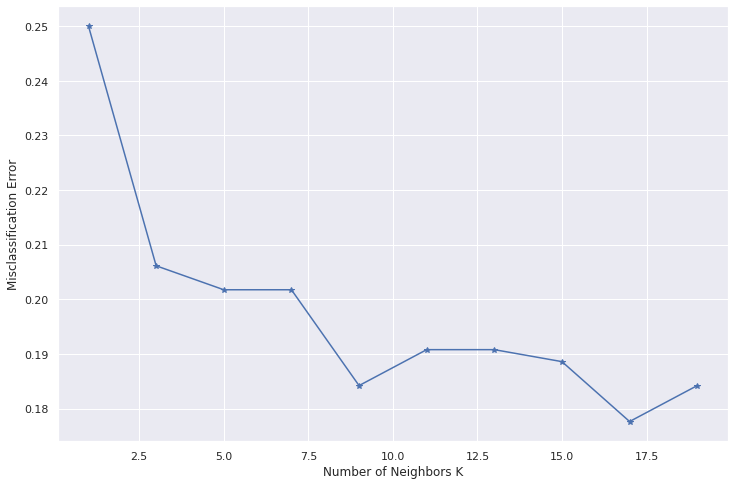

In [ ]:
# plot misclassification error vs k
plt.figure(figsize=(12,8))
plt.plot(range(1,20,2), MCE, marker='*')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

**K=17**

In [ ]:
KNN_model=KNeighborsClassifier(n_neighbors=17)
KNN_model.fit(X_train,train_labels)

KNeighborsClassifier(n_neighbors=17)

0.8510838831291234


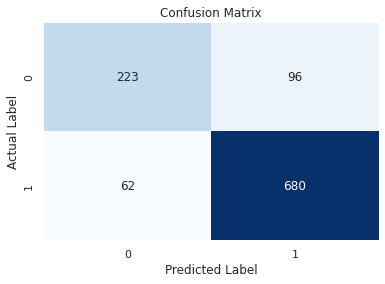

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74       319
         1.0       0.88      0.92      0.90       742

    accuracy                           0.85      1061
   macro avg       0.83      0.81      0.82      1061
weighted avg       0.85      0.85      0.85      1061



In [ ]:
y_train_predict=KNN_model.predict(X_train)
KNN_model_score=KNN_model.score(X_train,train_labels)
print(KNN_model_score)
sns.heatmap(confusion_matrix(train_labels,y_train_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(metrics.classification_report(train_labels,y_train_predict))

0.8223684210526315


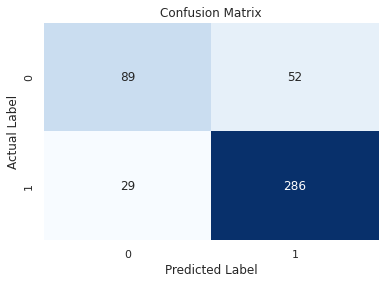

              precision    recall  f1-score   support

         0.0       0.75      0.63      0.69       141
         1.0       0.85      0.91      0.88       315

    accuracy                           0.82       456
   macro avg       0.80      0.77      0.78       456
weighted avg       0.82      0.82      0.82       456



In [ ]:
y_test_predict=KNN_model.predict(X_test)
KNN_model_score=KNN_model.score(X_test,test_labels)
print(KNN_model_score)
sns.heatmap(confusion_matrix(test_labels,y_test_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(metrics.classification_report(test_labels,y_test_predict))

In [ ]:
probs_train = KNN_model.predict_proba(X_train)
probs_train = probs_train[:, 1]
probs_test = KNN_model.predict_proba(X_test)
probs_test = probs_test[:, 1]
train_auc = roc_auc_score(train_labels, probs_train)
test_auc = roc_auc_score(test_labels, probs_test)
print(train_auc)
print(test_auc)

0.918822719245621
0.8640999662276259


**K=19**

In [ ]:
KNN_model=KNeighborsClassifier(n_neighbors=19)
KNN_model.fit(X_train,train_labels)

KNeighborsClassifier(n_neighbors=19)

In [ ]:
y_train_predict=KNN_model.predict(X_train)
KNN_model_score=KNN_model.score(X_train,train_labels)
print(KNN_model_score)
print(metrics.confusion_matrix(train_labels,y_train_predict))
print(metrics.classification_report(train_labels,y_train_predict))

0.8501413760603205
[[224  95]
 [ 64 678]]
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74       319
         1.0       0.88      0.91      0.90       742

    accuracy                           0.85      1061
   macro avg       0.83      0.81      0.82      1061
weighted avg       0.85      0.85      0.85      1061



In [ ]:
y_test_predict=KNN_model.predict(X_test)
KNN_model_score=KNN_model.score(X_test,test_labels)
print(KNN_model_score)
print(metrics.confusion_matrix(test_labels,y_test_predict))
print(metrics.classification_report(test_labels,y_test_predict))

0.8157894736842105
[[ 87  54]
 [ 30 285]]
              precision    recall  f1-score   support

         0.0       0.74      0.62      0.67       141
         1.0       0.84      0.90      0.87       315

    accuracy                           0.82       456
   macro avg       0.79      0.76      0.77       456
weighted avg       0.81      0.82      0.81       456



**K=10**

In [ ]:
KNN_model=KNeighborsClassifier(n_neighbors=10)
KNN_model.fit(X_train,train_labels)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_train_predict=KNN_model.predict(X_train)
KNN_model_score=KNN_model.score(X_train,train_labels)
print(KNN_model_score)
print(metrics.confusion_matrix(train_labels,y_train_predict))
print(metrics.classification_report(train_labels,y_train_predict))

0.8557964184731386
[[242  77]
 [ 76 666]]
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       319
         1.0       0.90      0.90      0.90       742

    accuracy                           0.86      1061
   macro avg       0.83      0.83      0.83      1061
weighted avg       0.86      0.86      0.86      1061



In [ ]:
y_test_predict=KNN_model.predict(X_test)
KNN_model_score=KNN_model.score(X_test,test_labels)
print(KNN_model_score)
print(metrics.confusion_matrix(test_labels,y_test_predict))
print(metrics.classification_report(test_labels,y_test_predict))

0.8114035087719298
[[ 91  50]
 [ 36 279]]
              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68       141
         1.0       0.85      0.89      0.87       315

    accuracy                           0.81       456
   macro avg       0.78      0.77      0.77       456
weighted avg       0.81      0.81      0.81       456



In [ ]:
KNN_model=KNeighborsClassifier(n_neighbors = 3,metric='euclidean')

# fitting the model
KNN_model.fit(X_train,train_labels)

# predict the response
y_test_predict = KNN_model.predict(X_test)

# evaluate accuracy
print("Accuracy Score for K=3 is ", KNN_model.score(X_test, test_labels))

# initiantiate learning model (k = 5)
KNN_model=KNeighborsClassifier(n_neighbors = 5,metric='euclidean')

# fitting the model
KNN_model.fit(X_train,train_labels)

# predict the response
y_test_predict = KNN_model.predict(X_test)

# evaluate accuracy
print("Accuracy Score for K=5 is ", KNN_model.score(X_test, test_labels))

# initiantiate learning model (k = 9)
from sklearn.neighbors import KNeighborsClassifier
KNN_model=KNeighborsClassifier(n_neighbors = 9,metric='euclidean')

# fitting the model
KNN_model.fit(X_train,train_labels)

# predict the response
y_test_predict = KNN_model.predict(X_test)

# evaluate accuracy
print("Accuracy Score for K=9 is ", KNN_model.score(X_test, test_labels))

Accuracy Score for K=3 is  0.793859649122807
Accuracy Score for K=5 is  0.7982456140350878
Accuracy Score for K=9 is  0.8157894736842105


**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
NB_model=GaussianNB()
NB_model.fit(X_train, train_labels)

GaussianNB()

In [ ]:
print(NB_model.score(X_train, train_labels))
print(NB_model.score(X_test, test_labels))

0.8407163053722903
0.8157894736842105


In [ ]:
ytest_predict =  NB_model.predict(X_test)
ytrain_predict = NB_model.predict(X_train)

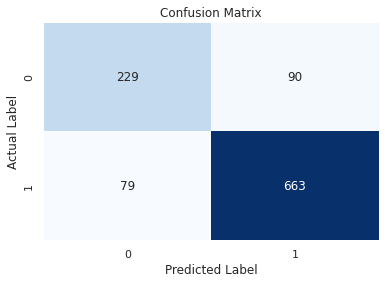

In [ ]:
confusion_matrix(train_labels, ytrain_predict)
sns.heatmap(confusion_matrix(train_labels, ytrain_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       319
         1.0       0.88      0.89      0.89       742

    accuracy                           0.84      1061
   macro avg       0.81      0.81      0.81      1061
weighted avg       0.84      0.84      0.84      1061



AUC: 0.888


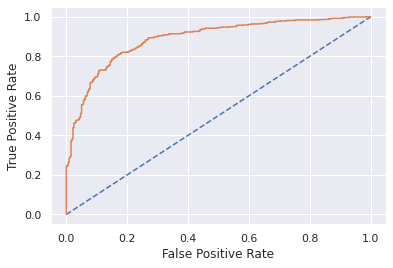

In [ ]:
probs = NB_model.predict_proba(X_train)
probs = probs[:, 1]
ct_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % ct_train_auc)
ct_train_fpr, ct_train_tpr, ct_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_train_fpr, ct_train_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

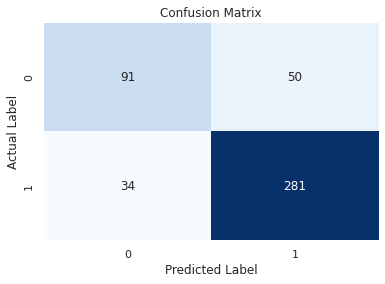

In [ ]:
confusion_matrix(test_labels, ytest_predict)
sns.heatmap(confusion_matrix(test_labels, ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

         0.0       0.73      0.65      0.68       141
         1.0       0.85      0.89      0.87       315

    accuracy                           0.82       456
   macro avg       0.79      0.77      0.78       456
weighted avg       0.81      0.82      0.81       456



AUC: 0.879


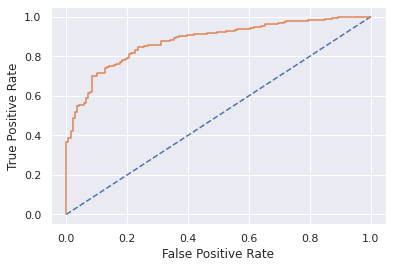

In [ ]:
probs = NB_model.predict_proba(X_test)
probs = probs[:, 1]
ct_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % ct_test_auc)
ct_test_fpr, ct_test_tpr, ct_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(ct_test_fpr, ct_test_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**1.6 Model Tuning, Bagging (Random Forest should be applied for Bagging), and Boosting.**

**Logistic Regression**

In [ ]:
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'tol': [0.0001,0.001,0.01], 
    'C': [1e-2, 1e-1, 1, 10, 100],
}

lr = LogisticRegression(random_state=123)

grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 10)

In [ ]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
best_grid

{'C': 10, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}


LogisticRegression(C=10, random_state=123, solver='saga', tol=0.01)

In [ ]:
print('model.score_train', best_grid.score(X_train, train_labels))
print('model.score_test', best_grid.score(X_test, test_labels))

model.score_train 0.8444863336475024
model.score_test 0.8201754385964912


In [ ]:
ytest_predict =  best_grid.predict(X_test)
ytrain_predict = best_grid.predict(X_train)

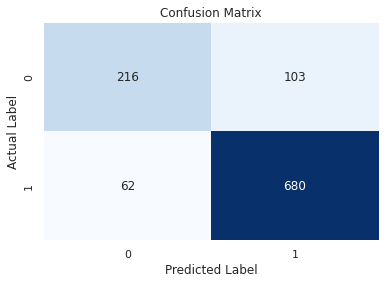

              precision    recall  f1-score   support

         0.0       0.78      0.68      0.72       319
         1.0       0.87      0.92      0.89       742

    accuracy                           0.84      1061
   macro avg       0.82      0.80      0.81      1061
weighted avg       0.84      0.84      0.84      1061



In [ ]:
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(train_labels, ytrain_predict))

AUC: 0.892


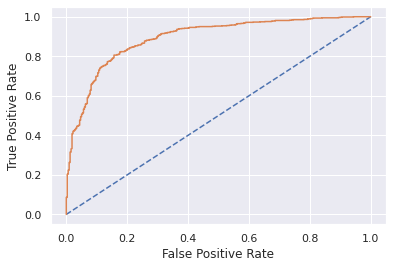

In [ ]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

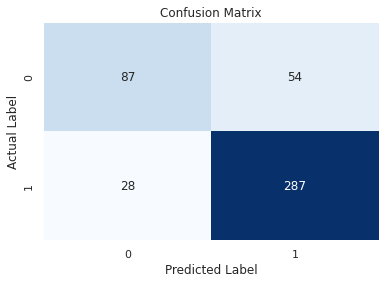

              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68       141
         1.0       0.84      0.91      0.88       315

    accuracy                           0.82       456
   macro avg       0.80      0.76      0.78       456
weighted avg       0.82      0.82      0.81       456



In [ ]:
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, ytest_predict))

AUC: 0.882


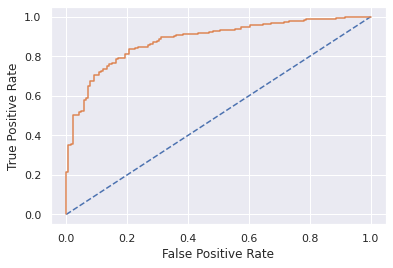

In [ ]:
probs_test = best_grid.predict_proba(X_test)

probs_test = probs_test[:, 1]

auc = roc_auc_score(test_labels, probs_test)
print('AUC: %.3f' % auc)

test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(test_fpr, test_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**LDA**

In [ ]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [0, 1, 0.01],
    'tol': [0.0001,0.001,0.01], 
}

lda = LinearDiscriminantAnalysis()

grid_search = GridSearchCV(estimator = lda, param_grid = param_grid, cv = 10)

In [ ]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
best_grid

{'shrinkage': 1, 'solver': 'lsqr', 'tol': 0.0001}


LinearDiscriminantAnalysis(shrinkage=1, solver='lsqr')

In [ ]:
ytest_predict =  best_grid.predict(X_test)
ytrain_predict = best_grid.predict(X_train)

In [ ]:
print('model.score_train', model.score(X_train, train_labels))
print('model.score_test', model.score(X_test, test_labels))

model.score_train 0.8388312912346843
model.score_test 0.8245614035087719


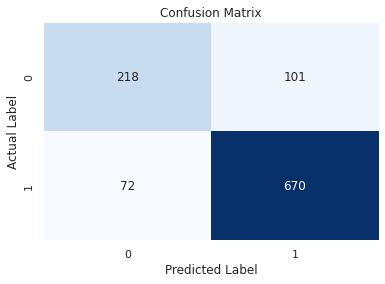

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72       319
         1.0       0.87      0.90      0.89       742

    accuracy                           0.84      1061
   macro avg       0.81      0.79      0.80      1061
weighted avg       0.83      0.84      0.83      1061



In [ ]:
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(train_labels, ytrain_predict))

AUC: 0.888


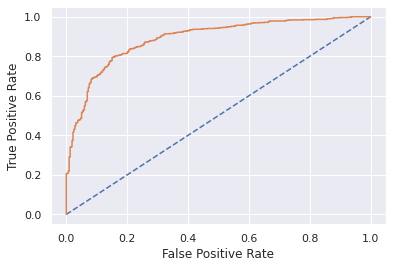

In [ ]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

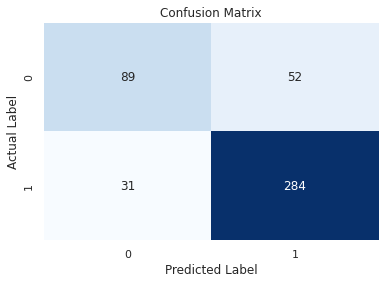

              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68       141
         1.0       0.85      0.90      0.87       315

    accuracy                           0.82       456
   macro avg       0.79      0.77      0.78       456
weighted avg       0.81      0.82      0.81       456



In [ ]:
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, ytest_predict))

AUC: 0.881


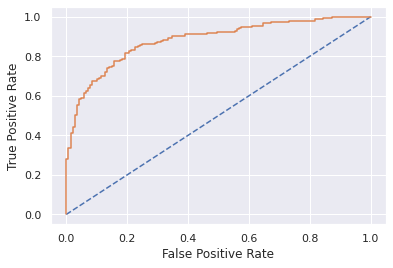

In [ ]:
probs_test = best_grid.predict_proba(X_test)

probs_test = probs_test[:, 1]

auc = roc_auc_score(test_labels, probs_test)
print('AUC: %.3f' % auc)

test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(test_fpr, test_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Ada Boost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=123)
ADB_model.fit(X_train, train_labels)

AdaBoostClassifier(n_estimators=100, random_state=123)

In [ ]:
ytest_predict =  ADB_model.predict(X_test)
ytrain_predict = ADB_model.predict(X_train)

Model_Score_train:  0.8539114043355325


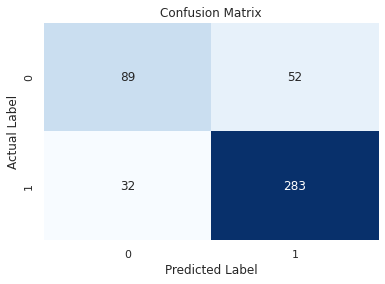

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75       319
         1.0       0.89      0.90      0.90       742

    accuracy                           0.85      1061
   macro avg       0.83      0.82      0.82      1061
weighted avg       0.85      0.85      0.85      1061



In [ ]:
cart_train_acc=ADB_model.score(X_train,train_labels)
print('Model_Score_train: ', cart_train_acc)
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(test_labels, y_test_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(train_labels, ytrain_predict))

AUC: 0.916


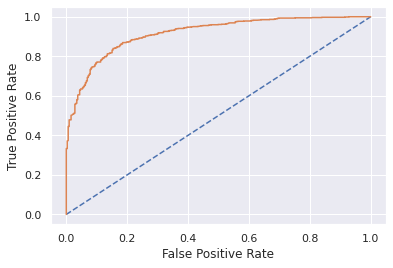

In [ ]:
# predict probabilities
probs = ADB_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Model_Score_test:  0.8070175438596491


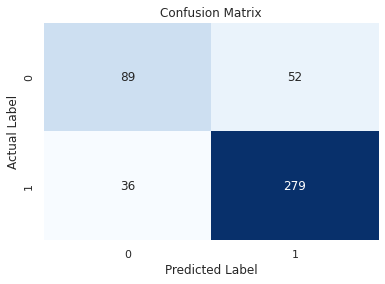

              precision    recall  f1-score   support

         0.0       0.71      0.63      0.67       141
         1.0       0.84      0.89      0.86       315

    accuracy                           0.81       456
   macro avg       0.78      0.76      0.77       456
weighted avg       0.80      0.81      0.80       456



In [ ]:
cart_test_acc=ADB_model.score(X_test,test_labels)
print('Model_Score_test: ',cart_test_acc)
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, ytest_predict))

AUC: 0.861


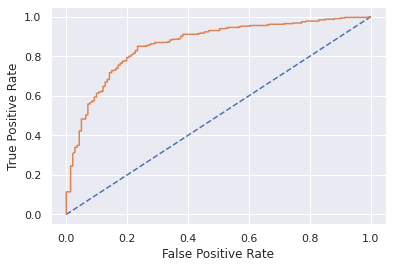

In [ ]:
probs_test = ADB_model.predict_proba(X_test)

probs_test = probs_test[:, 1]

auc = roc_auc_score(test_labels, probs_test)
print('AUC: %.3f' % auc)

test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(test_fpr, test_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(random_state=123)
gbcl = gbcl.fit(X_train, train_labels)

In [ ]:
ytest_predict =  gbcl.predict(X_test)
ytrain_predict = gbcl.predict(X_train)

Model_Score_train:  0.8906691800188501


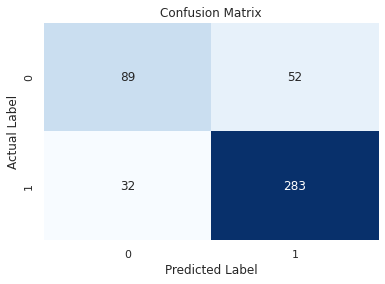

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       319
         1.0       0.91      0.94      0.92       742

    accuracy                           0.89      1061
   macro avg       0.88      0.86      0.87      1061
weighted avg       0.89      0.89      0.89      1061



In [ ]:
cart_train_acc=gbcl.score(X_train,train_labels)
print('Model_Score_train: ', cart_train_acc)
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(test_labels, y_test_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(train_labels, ytrain_predict))

AUC: 0.952


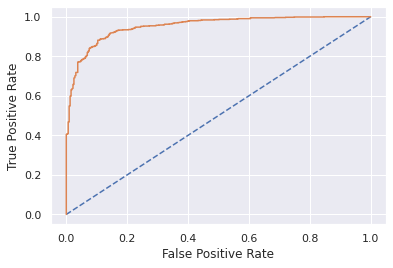

In [ ]:
# predict probabilities
probs = gbcl.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Model_Score_test:  0.8092105263157895


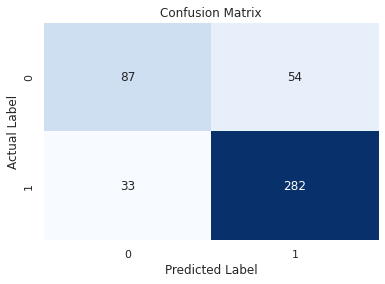

              precision    recall  f1-score   support

         0.0       0.72      0.62      0.67       141
         1.0       0.84      0.90      0.87       315

    accuracy                           0.81       456
   macro avg       0.78      0.76      0.77       456
weighted avg       0.80      0.81      0.80       456



In [ ]:
cart_test_acc=gbcl.score(X_test,test_labels)
print('Model_Score_test: ',cart_test_acc)
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, ytest_predict))

AUC: 0.888


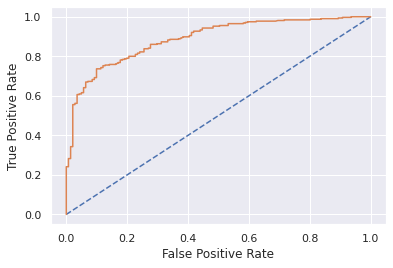

In [ ]:
probs_test = gbcl.predict_proba(X_test)

probs_test = probs_test[:, 1]

auc = roc_auc_score(test_labels, probs_test)
print('AUC: %.3f' % auc)

test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(test_fpr, test_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Bagging**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
X_train,X_test, Y_train,Y_test= train_test_split(X,y,test_size=0.30,random_state=123)

In [ ]:
cart=DecisionTreeClassifier()
Bagging_model=BaggingClassifier(base_estimator=cart,n_estimators=100, random_state=123)

Bagging_model.fit(X_train,Y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=123)

Model_Score_train:  0.9990574929311969


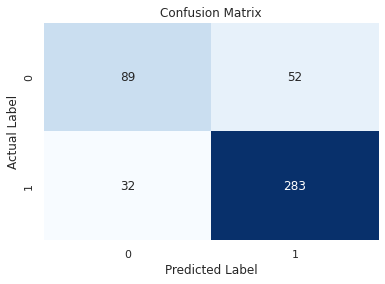

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       319
         1.0       0.91      0.94      0.92       742

    accuracy                           0.89      1061
   macro avg       0.88      0.86      0.87      1061
weighted avg       0.89      0.89      0.89      1061



In [ ]:
cart_train_acc=Bagging_model.score(X_train,train_labels)
print('Model_Score_train: ', cart_train_acc)
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(test_labels, y_test_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(train_labels, ytrain_predict))

AUC: 1.000


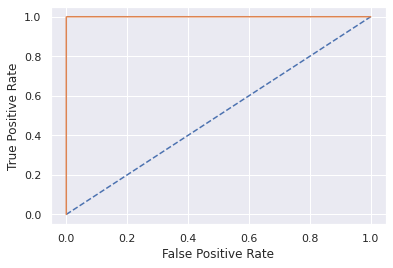

In [ ]:
# predict probabilities
probs = Bagging_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Model_Score_test:  0.8070175438596491


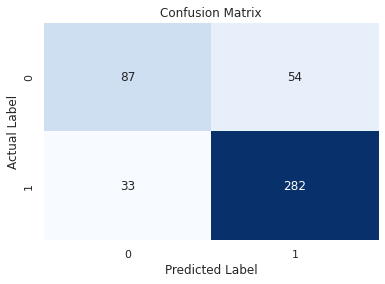

              precision    recall  f1-score   support

         0.0       0.72      0.62      0.67       141
         1.0       0.84      0.90      0.87       315

    accuracy                           0.81       456
   macro avg       0.78      0.76      0.77       456
weighted avg       0.80      0.81      0.80       456



In [ ]:
cart_test_acc=Bagging_model.score(X_test,test_labels)
print('Model_Score_test: ',cart_test_acc)
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, ytest_predict))

AUC: 0.850


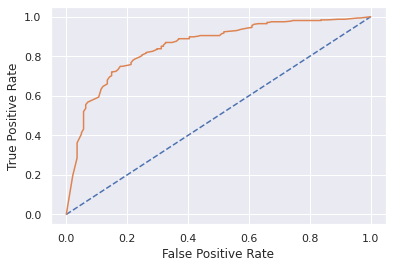

In [ ]:
probs_test = Bagging_model.predict_proba(X_test)

probs_test = probs_test[:, 1]

auc = roc_auc_score(test_labels, probs_test)
print('AUC: %.3f' % auc)

test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(test_fpr, test_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model=KNeighborsClassifier()
Bagging_model=BaggingClassifier(base_estimator=KNN_model,n_estimators=100, random_state=123)
Bagging_model.fit(X_train,Y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=100,
                  random_state=123)

Model_Score_train:  0.8774740810556079


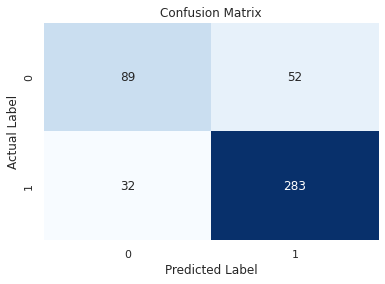

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       319
         1.0       0.91      0.94      0.92       742

    accuracy                           0.89      1061
   macro avg       0.88      0.86      0.87      1061
weighted avg       0.89      0.89      0.89      1061



In [ ]:
cart_train_acc=Bagging_model.score(X_train,train_labels)
print('Model_Score_train: ', cart_train_acc)
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(test_labels, y_test_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(train_labels, ytrain_predict))

AUC: 0.947


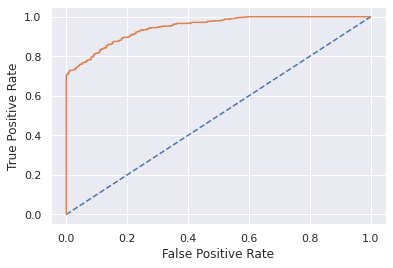

In [ ]:
# predict probabilities
probs = Bagging_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Model_Score_test:  0.7982456140350878


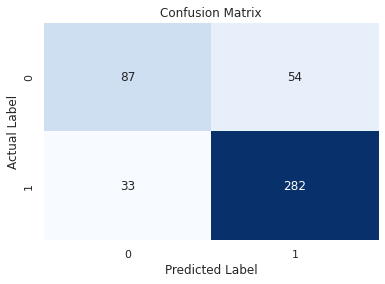

              precision    recall  f1-score   support

         0.0       0.72      0.62      0.67       141
         1.0       0.84      0.90      0.87       315

    accuracy                           0.81       456
   macro avg       0.78      0.76      0.77       456
weighted avg       0.80      0.81      0.80       456



In [ ]:
cart_test_acc=Bagging_model.score(X_test,test_labels)
print('Model_Score_test: ',cart_test_acc)
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, ytest_predict))

AUC: 0.845


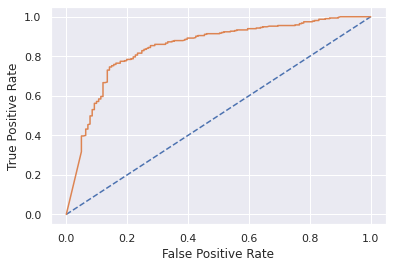

In [ ]:
probs_test = Bagging_model.predict_proba(X_test)

probs_test = probs_test[:, 1]

auc = roc_auc_score(test_labels, probs_test)
print('AUC: %.3f' % auc)

test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(test_fpr, test_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model=RandomForestClassifier()
Bagging_model=BaggingClassifier(base_estimator=RF_model,n_estimators=100, random_state=123)
Bagging_model.fit(X_train,Y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=100,
                  random_state=123)

Model_Score_train:  0.9707822808671065


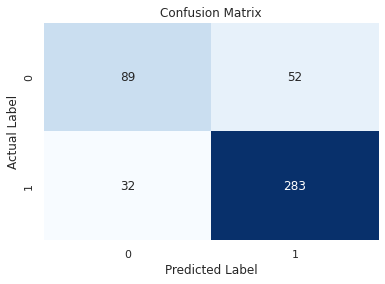

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       319
         1.0       0.91      0.94      0.92       742

    accuracy                           0.89      1061
   macro avg       0.88      0.86      0.87      1061
weighted avg       0.89      0.89      0.89      1061



In [ ]:
cart_train_acc=Bagging_model.score(X_train,train_labels)
print('Model_Score_train: ', cart_train_acc)
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(test_labels, y_test_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(train_labels, ytrain_predict))

AUC: 0.997


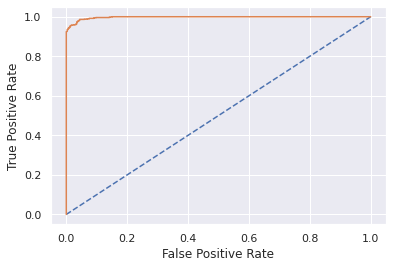

In [ ]:
# predict probabilities
probs = Bagging_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Model_Score_test:  0.8092105263157895


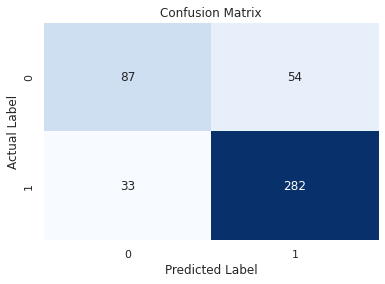

              precision    recall  f1-score   support

         0.0       0.72      0.62      0.67       141
         1.0       0.84      0.90      0.87       315

    accuracy                           0.81       456
   macro avg       0.78      0.76      0.77       456
weighted avg       0.80      0.81      0.80       456



In [ ]:
cart_test_acc=Bagging_model.score(X_test,test_labels)
print('Model_Score_test: ',cart_test_acc)
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, ytest_predict))

AUC: 0.876


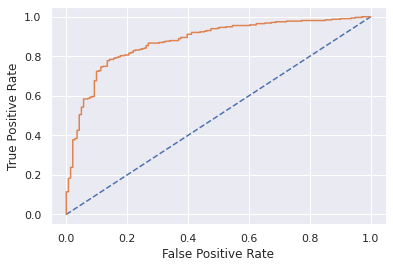

In [ ]:
probs_test = Bagging_model.predict_proba(X_test)

probs_test = probs_test[:, 1]

auc = roc_auc_score(test_labels, probs_test)
print('AUC: %.3f' % auc)

test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(test_fpr, test_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### **2.1 Find the number of characters, words, and sentences for the mentioned documents.**

In [ ]:
df = inaugural.fileids()

In [ ]:
df[0:10]

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt',
 '1809-Madison.txt',
 '1813-Madison.txt',
 '1817-Monroe.txt',
 '1821-Monroe.txt',
 '1825-Adams.txt']

In [ ]:
inaugural.raw(df)

'Fellow-Citizens of the Senate and of the House of Representatives:\n\nAmong the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the 14th day of the present month. On the one hand, I was summoned by my Country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years -- a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual waste committed on it by time. On the other hand, the magnitude and difficulty of the trust to which the voice of my country called me, being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his qualifications, could not

In [ ]:
Roosevelt = nltk.corpus.inaugural.words('1941-Roosevelt.txt')
Roosevelt

['On', 'each', 'national', 'day', 'of', 'inauguration', ...]

In [ ]:
len(Roosevelt)

1536

In [ ]:
Roosevelt = nltk.corpus.inaugural.raw('1941-Roosevelt.txt')
len(Roosevelt)

7571

In [ ]:
Kennedy= nltk.corpus.inaugural.words('1961-Kennedy.txt')
len(Kennedy)

1546

In [ ]:
Kennedy = nltk.corpus.inaugural.raw('1961-Kennedy.txt')
len(Kennedy)

7618

In [ ]:
Nixon= nltk.corpus.inaugural.words('1973-Nixon.txt')
len(Nixon)

2028

In [ ]:
Nixon = nltk.corpus.inaugural.raw('1973-Nixon.txt')
len(Nixon)

9991

In [ ]:
len(inaugural.sents('1941-Roosevelt.txt'))

68

In [ ]:
len(inaugural.sents('1961-Kennedy.txt'))

52

In [ ]:
len(inaugural.sents('1973-Nixon.txt'))

69

In [ ]:
# Defining a variable 'stopwords' which contains the list of punctuations from the string library and the english stopwords
# from nltk
stopwords = nltk.corpus.stopwords.words('english') +list(string.punctuation)
stopwords.extend(["http","bit","bitly","bit ly", "dear", "im", "i'm", "please", '--'])

# Converting all the words to lower case
all_words = (w.lower() for w in inaugural.words('1941-Roosevelt.txt')) 
# Only keeping the words which are not the 'stopwords'
all_words_clean_Roosevelt = [word for word in all_words if word not in stopwords]


# Creating a frequency distribution of the lower case words which does not contain any stopwords
all_words_freq_Roosevelt = nltk.FreqDist(all_words_clean_Roosevelt)

# Extracting the  most common 2000 words after the list of words have been converted to lowercase and the stopwords 
word_features_Roosevelt = [item[0] for item in all_words_freq_Roosevelt.most_common(2000)]


In [ ]:
# Defining a variable 'stopwords' which contains the list of punctuations from the string library and the english stopwords
# from nltk
stopwords = nltk.corpus.stopwords.words('english') +list(string.punctuation)
stopwords.extend(["http","bit","bitly","bit ly", "dear", "im", "i'm", "please", '--'])

# Converting all the words to lower case
all_words = (w.lower() for w in inaugural.words('1961-Kennedy.txt')) 
# Only keeping the words which are not the 'stopwords'
all_words_clean = [word for word in all_words if word not in stopwords]


# Creating a frequency distribution of the lower case words which does not contain any stopwords
all_words_freq_Kennedy = nltk.FreqDist(all_words_clean)

# Extracting the  most common 2000 words after the list of words have been converted to lowercase and the stopwords 
word_features_Kennedy = [item[0] for item in all_words_freq.most_common(2000)]


In [ ]:
# Defining a variable 'stopwords' which contains the list of punctuations from the string library and the english stopwords
# from nltk
stopwords = nltk.corpus.stopwords.words('english') +list(string.punctuation)
stopwords.extend(["http","bit","bitly","bit ly", "dear", "im", "i'm", "please", '--', 'of'])

# Converting all the words to lower case
all_words = (w.lower() for w in inaugural.words('1973-Nixon.txt')) 
# Only keeping the words which are not the 'stopwords'
all_words_clean = [word for word in all_words if word not in stopwords]


# Creating a frequency distribution of the lower case words which does not contain any stopwords
all_words_freq_Nixon = nltk.FreqDist(all_words_clean)

# Extracting the  most common 2000 words after the list of words have been converted to lowercase and the stopwords 
word_features_Nixon = [item[0] for item in all_words_freq.most_common(2000)]


In [ ]:
word_features[:10]

['--',
 'nation',
 'know',
 'spirit',
 'life',
 'democracy',
 'us',
 'people',
 'america',
 'years']

In [ ]:
Roosevelt[0:205]

"On each national day of inauguration since 1789, the people have renewed their sense of dedication to the United States.\n\nIn Washington's day the task of the people was to create and weld together a nation"

In [ ]:
Nixon[0:198]

'Mr. Vice President, Mr. Speaker, Mr. Chief Justice, Senator Cook, Mrs. Eisenhower, and my fellow citizens of this great and good country we share together:\n\nWhen we met here four years ago, America '

In [ ]:
Kennedy[:211]

'Vice President Johnson, Mr. Speaker, Mr. Chief Justice, President Eisenhower, Vice President Nixon, President Truman, reverend clergy, fellow citizens, we observe today not a victory of party, but a celebration '

In [ ]:
nltk.FreqDist(all_words_freq_Roosevelt).most_common(3)

[('nation', 12), ('know', 10), ('spirit', 9)]

In [ ]:
nltk.FreqDist(all_words_freq_Nixon).most_common(3)

[('us', 26), ('let', 22), ('america', 21)]

In [ ]:
nltk.FreqDist(all_words_freq_Kennedy).most_common(3)

[('let', 16), ('us', 12), ('world', 8)]

**Word Cloud**

In [ ]:
words = ' '.join(word_features_Roosevelt)

In [ ]:
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

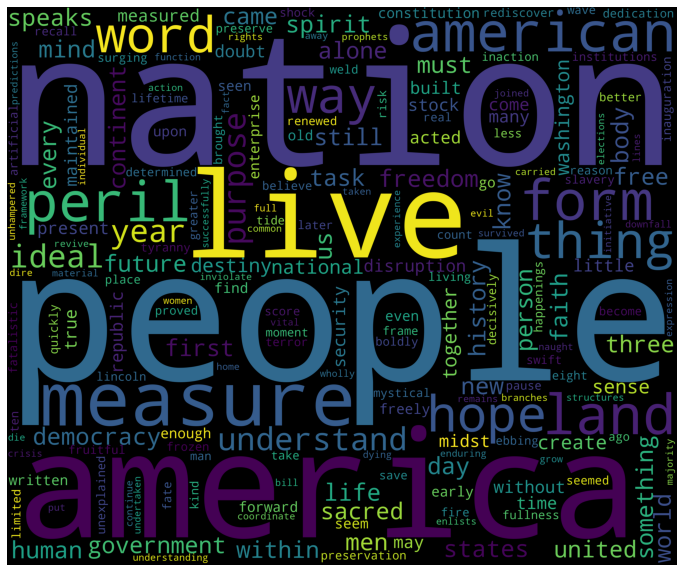

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
words = ' '.join(word_features_Kennedy)

In [ ]:
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

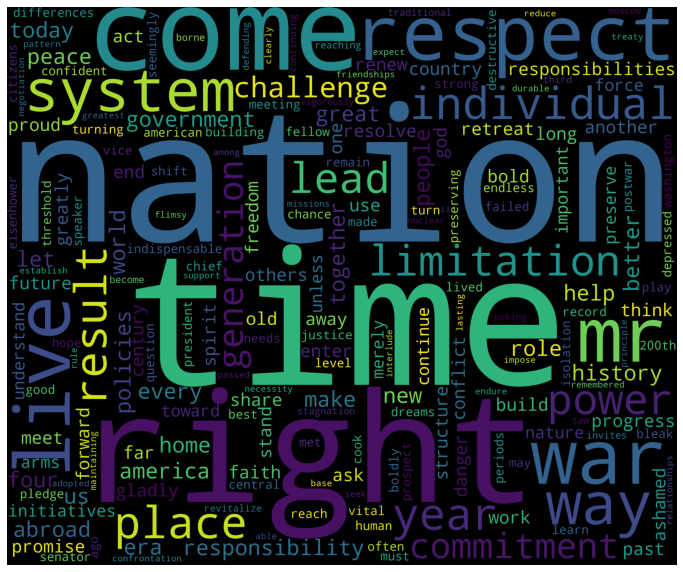

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
words = ' '.join(word_features_Nixon)

In [ ]:
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

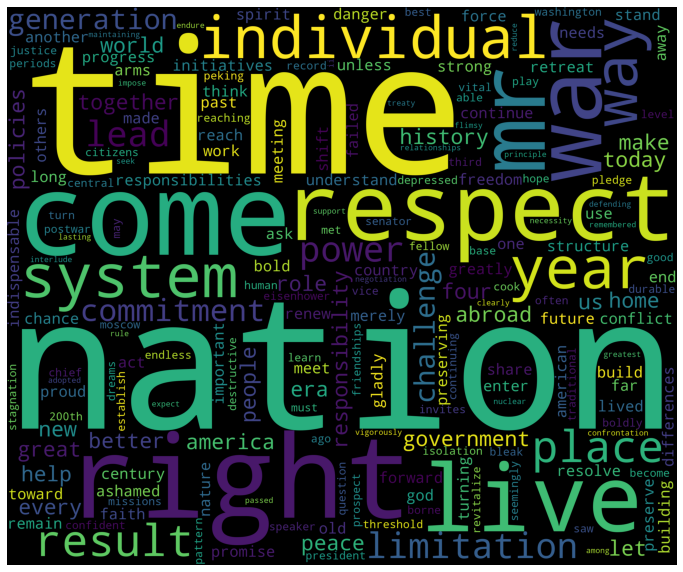

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()